In [4]:
import os
import json

def clean_and_filter_json(input_json_file, output_json_file, image_dir):
    """
    Cleans and filters the dataset to retain only the entries that have corresponding images.
    """
    with open(input_json_file, 'r') as f:
        data = json.load(f)
    
    filtered_data = []
    for entry in data:
        image_path = os.path.join(image_dir, entry['image'])
        if os.path.exists(image_path):
            filtered_data.append(entry)
    
    with open(output_json_file, 'w') as f:
        json.dump(filtered_data, f)
    
    print(f"Filtered dataset saved to {output_json_file} with {len(filtered_data)} entries.")

# Paths for the datasets
train_json_file = "/Users/krutikotadia/Desktop/DLP Project/Annotations/cleaned_train.json"
filtered_train_json_file = "/Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_train.json"
train_image_dir = "/Users/krutikotadia/Desktop/DLP Project/train/images_train"

val_json_file = "/Users/krutikotadia/Desktop/DLP Project/Annotations/val.json"
filtered_val_json_file = "/Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_val.json"
val_image_dir = "/Users/krutikotadia/Desktop/DLP Project/val/images_val"

test_json_file = "/Users/krutikotadia/Desktop/DLP Project/Annotations/test.json"
filtered_test_json_file = "/Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_test.json"
test_image_dir = "/Users/krutikotadia/Desktop/DLP Project/test/images_test"

# Clean and filter JSON files
clean_and_filter_json(train_json_file, filtered_train_json_file, train_image_dir)
clean_and_filter_json(val_json_file, filtered_val_json_file, val_image_dir)
clean_and_filter_json(test_json_file, filtered_test_json_file, test_image_dir)


Filtered dataset saved to /Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_train.json with 20523 entries.
Filtered dataset saved to /Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_val.json with 4319 entries.
Filtered dataset saved to /Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_test.json with 7323 entries.


In [7]:
import random
import torch
from PIL import Image
from torchvision import transforms
from transformers import BertTokenizer

# Paths (filtered files from previous step)
filtered_train_json_file = "/Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_train.json"
filtered_train_image_dir = "/Users/krutikotadia/Desktop/DLP Project/train/images_train"
filtered_val_json_file = "/Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_val.json"
filtered_val_image_dir = "/Users/krutikotadia/Desktop/DLP Project/val/images_val"
filtered_test_json_file = "/Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_test.json"
filtered_test_image_dir = "/Users/krutikotadia/Desktop/DLP Project/test/images_test"

# Constants
MAX_SEQ_LEN = 30
IMG_SIZE = (224, 224)
BERT_MODEL_NAME = 'bert-base-uncased'

# Initialize tokenizer and image transformations
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
image_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_and_limit(json_file, image_dir, subset_size=None):
    """
    Preprocess the dataset and limit its size.
    Handles cases where 'answers' key is missing but 'answer' key exists.
    Returns tokenized questions, attention masks, images, and answers.
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    if subset_size:
        data = random.sample(data, min(len(data), subset_size))  # Ensure subset size does not exceed available data

    input_ids, attention_masks, images, answers = [], [], [], []
    for entry in data:
        # Check if the entry has the required keys
        if 'question' not in entry or 'image' not in entry:
            print(f"Skipping entry due to missing keys: {entry}")
            continue

        # Tokenize question
        encoded = tokenizer(
            entry['question'],
            max_length=MAX_SEQ_LEN,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
        
        # Load and transform image
        image_path = os.path.join(image_dir, entry['image'])
        try:
            image = Image.open(image_path).convert("RGB")
            images.append(image_transforms(image))
        except FileNotFoundError:
            print(f"Image not found: {image_path}")
            continue
        
        # Collect the most common valid answer if 'answers' exist
        if 'answers' in entry:
            valid_answers = [ans['answer'] for ans in entry['answers'] if 'answer' in ans and ans.get('answer_confidence') in ['yes', 'maybe']]
            answers.append(valid_answers[0] if valid_answers else 'unanswerable')
        elif 'answer' in entry:  # Use the direct 'answer' key if 'answers' is missing
            answers.append(entry['answer'])
        else:
            answers.append('unanswerable')  # Default fallback

    # Check if we have valid data
    if not input_ids or not images:
        raise RuntimeError("No valid data found after preprocessing.")

    return (
        torch.stack(input_ids),
        torch.stack(attention_masks),
        torch.stack(images),
        answers
    )

# Preprocess and limit datasets
train_input_ids, train_attention_masks, train_images, train_answers = preprocess_and_limit(
    filtered_train_json_file, filtered_train_image_dir, subset_size=8000)

val_input_ids, val_attention_masks, val_images, val_answers = preprocess_and_limit(
    filtered_val_json_file, filtered_val_image_dir, subset_size=2000)

test_input_ids, test_attention_masks, test_images, test_answers = preprocess_and_limit(
    filtered_test_json_file, filtered_test_image_dir, subset_size=2000)

print("Data preprocessing and limiting completed.")


Data preprocessing and limiting completed.


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torchvision import transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder

# Define the VQADataset class
class VQADataset(Dataset):
    def __init__(self, input_ids, attention_masks, images, labels=None):
        """
        Initialize the VQA Dataset.
        Args:
            input_ids: List of tokenized questions (torch.Tensor).
            attention_masks: List of attention masks for tokenized questions.
            images: List of preprocessed image tensors.
            labels: Encoded answer labels (optional).
        """
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.input_ids[idx], self.attention_masks[idx], self.images[idx], self.labels[idx]
        return self.input_ids[idx], self.attention_masks[idx], self.images[idx]

# Extend LabelEncoder with additional labels
def extend_label_encoder(label_encoder, additional_labels):
    current_classes = set(label_encoder.classes_)
    new_classes = set(additional_labels)
    combined_classes = list(current_classes | new_classes)
    combined_classes.sort()  # Keep classes sorted
    label_encoder.classes_ = np.array(combined_classes)  # Update classes as a NumPy array
    return label_encoder

# Image transformation pipeline
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Initialize and fit LabelEncoder on training answers
label_encoder = LabelEncoder()
label_encoder.fit(train_answers)

# Extend LabelEncoder with validation and test answers
label_encoder = extend_label_encoder(label_encoder, val_answers)
label_encoder = extend_label_encoder(label_encoder, test_answers)

# Encode answers
train_encoded_answers = torch.tensor(label_encoder.transform(train_answers))
val_encoded_answers = torch.tensor(label_encoder.transform(val_answers))
test_encoded_answers = torch.tensor(label_encoder.transform(test_answers))

# Create Dataset objects
train_dataset = VQADataset(train_input_ids, train_attention_masks, train_images, train_encoded_answers)
val_dataset = VQADataset(val_input_ids, val_attention_masks, val_images, val_encoded_answers)
test_dataset = VQADataset(test_input_ids, test_attention_masks, test_images, test_encoded_answers)

# Create DataLoader objects
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders are ready.")


DataLoaders are ready.


In [13]:
import torch.nn as nn
from torchvision.models import resnet18
from transformers import BertModel
import torch.optim as optim
from tqdm import tqdm

# Define the Baseline VQA Model
class BaselineVQAModel(nn.Module):
    def __init__(self, num_classes):
        super(BaselineVQAModel, self).__init__()
        # Pretrained ResNet for image feature extraction
        self.image_model = resnet18(pretrained=True)
        self.image_model.fc = nn.Identity()  # Remove ResNet's final classification layer

        # Pretrained BERT for text feature extraction
        self.text_model = BertModel.from_pretrained("bert-base-uncased")

        # Fully connected layers to combine image and text features
        self.fc = nn.Sequential(
            nn.Linear(512 + 768, 512),  # Combine ResNet (512) and BERT (768) features
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)  # Output layer with `num_classes` neurons
        )

    def forward(self, input_ids, attention_mask, images):
        # Extract image features
        image_features = self.image_model(images)  # Shape: [batch_size, 512]

        # Extract text features
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # [CLS] token embeddings

        # Concatenate image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)

        # Classify combined features
        output = self.fc(combined_features)
        return output

# Initialize the Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_classes = len(label_encoder.classes_)  # Total number of unique answers
model = BaselineVQAModel(num_classes).to(device)

# Define Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_baseline_model(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0

        for input_ids, attention_masks, images, labels in tqdm(train_loader):
            # Move data to device
            input_ids, attention_masks, images, labels = (
                input_ids.to(device),
                attention_masks.to(device),
                images.to(device),
                labels.to(device)
            )

            # Forward pass
            outputs = model(input_ids, attention_masks, images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}")

# Train the Model
train_baseline_model(model, train_loader, epochs=5)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5


100%|██████████| 250/250 [16:54<00:00,  4.06s/it]


Epoch 1 - Loss: 5.3476
Epoch 2/5


100%|██████████| 250/250 [17:35<00:00,  4.22s/it]


Epoch 2 - Loss: 4.7332
Epoch 3/5


100%|██████████| 250/250 [17:40<00:00,  4.24s/it]


Epoch 3 - Loss: 4.4540
Epoch 4/5


100%|██████████| 250/250 [16:40<00:00,  4.00s/it]


Epoch 4 - Loss: 4.1055
Epoch 5/5


100%|██████████| 250/250 [16:45<00:00,  4.02s/it]

Epoch 5 - Loss: 3.8315


In [14]:
from sklearn.metrics import accuracy_score

# Evaluation Function
def evaluate_model(model, val_loader):
    """
    Evaluate the trained model on the validation dataset.
    Args:
        model: Trained BaselineVQAModel.
        val_loader: DataLoader for validation data.
    Returns:
        accuracy: Validation accuracy as a percentage.
    """
    model.eval()  # Set model to evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for input_ids, attention_masks, images, labels in tqdm(val_loader):
            # Move data to device
            input_ids, attention_masks, images, labels = (
                input_ids.to(device),
                attention_masks.to(device),
                images.to(device),
                labels.to(device)
            )

            # Forward pass
            outputs = model(input_ids, attention_masks, images)

            # Get predictions
            preds = torch.argmax(outputs, dim=1)

            # Collect predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Run evaluation
print("Evaluating the model on validation data...")
evaluate_model(model, val_loader)


Evaluating the model on validation data...


100%|██████████| 63/63 [01:05<00:00,  1.04s/it]

Validation Accuracy: 28.75%


0.2875

In [15]:
# def analyze_predictions(model, val_loader, label_encoder):
#     """
#     Analyze a few predictions from the model and compare them with ground truth.
#     """
#     model.eval()
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'

#     with torch.no_grad():
#         for input_ids, attention_masks, images, labels in val_loader:
#             input_ids, attention_masks, images, labels = (
#                 input_ids.to(device),
#                 attention_masks.to(device),
#                 images.to(device),
#                 labels.to(device)
#             )

#             outputs = model(input_ids, attention_masks, images)
#             preds = torch.argmax(outputs, dim=1)

#             for i in range(5):  # Print first 5 predictions
#                 pred_label = label_encoder.inverse_transform([preds[i].item()])[0]
#                 true_label = label_encoder.inverse_transform([labels[i].item()])[0]
#                 print(f"Prediction: {pred_label}, Ground Truth: {true_label}")

#             break  # Only process the first batch

# analyze_predictions(model, val_loader, label_encoder)


Prediction: unanswerable, Ground Truth: unanswerable
Prediction: unanswerable, Ground Truth: yes
Prediction: unanswerable, Ground Truth: unanswerable
Prediction: unanswerable, Ground Truth: unanswerable
Prediction: unanswerable, Ground Truth: unanswerable


In [16]:
import torch.optim as optim
from transformers import AdamW  # Optimizer from Hugging Face
from tqdm import tqdm

# Lower learning rate
learning_rate = 1e-5

# Optimizer for fine-tuning
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Loss function remains the same
criterion = nn.CrossEntropyLoss()

# Fine-tuning function
def fine_tune_model(model, train_loader, val_loader, epochs=5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.train()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()  # Set model to training mode
        total_loss = 0

        # Training loop
        for input_ids, attention_masks, images, labels in tqdm(train_loader):
            input_ids, attention_masks, images, labels = (
                input_ids.to(device),
                attention_masks.to(device),
                images.to(device),
                labels.to(device)
            )
            
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(input_ids, attention_masks, images)
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f}")
        
        # Evaluate after each epoch
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for input_ids, attention_masks, images, labels in tqdm(val_loader):
                input_ids, attention_masks, images, labels = (
                    input_ids.to(device),
                    attention_masks.to(device),
                    images.to(device),
                    labels.to(device)
                )
                outputs = model(input_ids, attention_masks, images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate validation accuracy
        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch + 1} Validation Accuracy: {accuracy * 100:.2f}%")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
fine_tune_model(model, train_loader, val_loader, epochs=5)


Epoch 1/5


100%|██████████| 250/250 [16:09<00:00,  3.88s/it]


Epoch 1 Training Loss: 3.5578


100%|██████████| 63/63 [01:14<00:00,  1.18s/it]


Epoch 1 Validation Accuracy: 27.05%
Epoch 2/5


100%|██████████| 250/250 [18:40<00:00,  4.48s/it]


Epoch 2 Training Loss: 3.4712


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Epoch 2 Validation Accuracy: 27.80%
Epoch 3/5


100%|██████████| 250/250 [18:47<00:00,  4.51s/it]


Epoch 3 Training Loss: 3.4168


100%|██████████| 63/63 [01:20<00:00,  1.27s/it]


Epoch 3 Validation Accuracy: 27.75%
Epoch 4/5


100%|██████████| 250/250 [18:39<00:00,  4.48s/it]


Epoch 4 Training Loss: 3.3725


100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


Epoch 4 Validation Accuracy: 27.45%
Epoch 5/5


100%|██████████| 250/250 [16:47<00:00,  4.03s/it]


Epoch 5 Training Loss: 3.3216


100%|██████████| 63/63 [01:15<00:00,  1.20s/it]

Epoch 5 Validation Accuracy: 27.95%


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionMechanism(nn.Module):
    def __init__(self, image_dim, text_dim, hidden_dim):
        super(AttentionMechanism, self).__init__()
        self.image_proj = nn.Linear(image_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.attention_proj = nn.Linear(hidden_dim, 1)

    def forward(self, image_features, text_features):
        """
        Compute attention scores and apply them to image features.
        Args:
            image_features: Tensor of shape [batch_size, num_regions, image_dim]
            text_features: Tensor of shape [batch_size, text_dim]
        Returns:
            attended_image_features: Tensor of shape [batch_size, image_dim]
        """
        # Project image and text features
        image_proj = self.image_proj(image_features)  # [batch_size, num_regions, hidden_dim]
        text_proj = self.text_proj(text_features).unsqueeze(1)  # [batch_size, 1, hidden_dim]

        # Compute attention scores
        combined_features = torch.tanh(image_proj + text_proj)  # [batch_size, num_regions, hidden_dim]
        attention_scores = self.attention_proj(combined_features).squeeze(-1)  # [batch_size, num_regions]

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, num_regions]

        # Compute attended image features
        attended_image_features = torch.sum(image_features * attention_weights.unsqueeze(-1), dim=1)  # [batch_size, image_dim]

        return attended_image_features


In [19]:
from torchvision.models import resnet18
from transformers import BertModel

class AttentionVQAModel(nn.Module):
    def __init__(self, num_classes):
        super(AttentionVQAModel, self).__init__()
        # Pretrained ResNet for image feature extraction
        self.image_model = resnet18(pretrained=True)
        self.image_model.fc = nn.Identity()  # Remove the final classification layer

        # Pretrained BERT for text feature extraction
        self.text_model = BertModel.from_pretrained('bert-base-uncased')

        # Attention mechanism
        self.attention = AttentionMechanism(image_dim=512, text_dim=768, hidden_dim=256)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, input_ids, attention_mask, images):
        # Extract image features
        image_features = self.image_model(images)  # Shape: [batch_size, num_regions, 512]
        
        # Extract text features
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # [CLS] token embeddings

        # Apply attention
        attended_image_features = self.attention(image_features, text_features)

        # Concatenate attended image features and text features
        combined_features = torch.cat((attended_image_features, text_features), dim=1)

        # Classify combined features
        output = self.fc(combined_features)
        return output


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from transformers import BertModel, AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Step 1: Define the Attention Mechanism
class AttentionMechanism(nn.Module):
    def __init__(self, image_dim, text_dim, hidden_dim):
        super(AttentionMechanism, self).__init__()
        self.image_proj = nn.Linear(image_dim, hidden_dim)
        self.text_proj = nn.Linear(text_dim, hidden_dim)
        self.attention_proj = nn.Linear(hidden_dim, 1)

    def forward(self, image_features, text_features):
        """
        Apply attention mechanism to image features based on text features.
        Args:
            image_features: Tensor of shape [batch_size, num_regions, image_dim]
            text_features: Tensor of shape [batch_size, text_dim]
        Returns:
            attended_image_features: Tensor of shape [batch_size, image_dim]
        """
        # Project features
        image_proj = self.image_proj(image_features)  # [batch_size, num_regions, hidden_dim]
        text_proj = self.text_proj(text_features).unsqueeze(1)  # [batch_size, 1, hidden_dim]

        # Compute attention scores
        combined_features = torch.tanh(image_proj + text_proj)  # [batch_size, num_regions, hidden_dim]
        attention_scores = self.attention_proj(combined_features).squeeze(-1)  # [batch_size, num_regions]

        # Normalize attention scores
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, num_regions]

        # Weighted sum of image features
        attended_image_features = torch.sum(image_features * attention_weights.unsqueeze(-1), dim=1)  # [batch_size, image_dim]

        return attended_image_features

# Step 2: Define the Attention-Based VQA Model
class AttentionVQAModel(nn.Module):
    def __init__(self, num_classes):
        super(AttentionVQAModel, self).__init__()
        # Image feature extractor
        self.image_model = resnet18(pretrained=True)
        self.image_model.fc = nn.Identity()  # Remove classification layer

        # Text feature extractor
        self.text_model = BertModel.from_pretrained('bert-base-uncased')

        # Attention mechanism
        self.attention = AttentionMechanism(image_dim=512, text_dim=768, hidden_dim=256)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(512 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_ids, attention_mask, images):
        # Extract image features
        image_features = self.image_model(images)  # Shape: [batch_size, 512]

        # Extract text features
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # [CLS] token embeddings

        # Apply attention mechanism
        attended_image_features = self.attention(image_features, text_features)

        # Combine image and text features
        combined_features = torch.cat((attended_image_features, text_features), dim=1)

        # Classify combined features
        output = self.fc(combined_features)
        return output

# Step 3: Fine-Tuning and Training
def train_attention_model(model, train_loader, val_loader, learning_rate=1e-5, epochs=5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    # Optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()  # Training mode
        total_loss = 0

        # Training loop
        for input_ids, attention_masks, images, labels in tqdm(train_loader):
            input_ids, attention_masks, images, labels = (
                input_ids.to(device),
                attention_masks.to(device),
                images.to(device),
                labels.to(device)
            )

            optimizer.zero_grad()  # Reset gradients
            outputs = model(input_ids, attention_masks, images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()  # Evaluation mode
        all_preds, all_labels = [], []

        with torch.no_grad():
            for input_ids, attention_masks, images, labels in tqdm(val_loader):
                input_ids, attention_masks, images, labels = (
                    input_ids.to(device),
                    attention_masks.to(device),
                    images.to(device),
                    labels.to(device)
                )
                outputs = model(input_ids, attention_masks, images)
                preds = torch.argmax(outputs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch + 1} Validation Accuracy: {accuracy * 100:.2f}%")

# Initialize and train the model
num_classes = len(label_encoder.classes_)
attention_model = AttentionVQAModel(num_classes)

train_attention_model(attention_model, train_loader, val_loader, learning_rate=1e-5, epochs=5)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_war

Epoch 1/5


100%|██████████| 250/250 [16:09<00:00,  3.88s/it]


Epoch 1 Training Loss: 6.1601


100%|██████████| 63/63 [01:14<00:00,  1.18s/it]


Epoch 1 Validation Accuracy: 28.65%
Epoch 2/5


100%|██████████| 250/250 [16:48<00:00,  4.03s/it]


Epoch 2 Training Loss: 5.4399


100%|██████████| 63/63 [01:14<00:00,  1.19s/it]


Epoch 2 Validation Accuracy: 28.65%
Epoch 3/5


100%|██████████| 250/250 [16:47<00:00,  4.03s/it]


Epoch 3 Training Loss: 5.1569


100%|██████████| 63/63 [01:15<00:00,  1.20s/it]


Epoch 3 Validation Accuracy: 29.35%
Epoch 4/5


100%|██████████| 250/250 [16:48<00:00,  4.03s/it]


Epoch 4 Training Loss: 4.9721


100%|██████████| 63/63 [01:15<00:00,  1.20s/it]


Epoch 4 Validation Accuracy: 29.15%
Epoch 5/5


100%|██████████| 250/250 [16:57<00:00,  4.07s/it]


Epoch 5 Training Loss: 4.8338


100%|██████████| 63/63 [01:17<00:00,  1.23s/it]

Epoch 5 Validation Accuracy: 29.55%


In [21]:
# Step: Preprocess Test Data
print("Preprocessing test data...")
test_input_ids, test_attention_masks, test_images, test_answers = preprocess_and_limit(
    filtered_test_json_file, filtered_test_image_dir, subset_size=2000
)
print("Test data preprocessing completed.")

# Step: Encode Test Answers
test_encoded_answers = torch.tensor(label_encoder.transform(test_answers))
print("Test answers encoded successfully.")

# Step: Create Test Dataset and DataLoader
test_dataset = VQADataset(
    test_input_ids, test_attention_masks, test_images, test_encoded_answers
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print("Test DataLoader created.")


Preprocessing test data...
Test data preprocessing completed.
Test answers encoded successfully.
Test DataLoader created.


In [22]:
# Evaluation function for test set
def evaluate_on_test(model, test_loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()  # Set model to evaluation mode
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_masks, images, labels in tqdm(test_loader):
            input_ids, attention_masks, images, labels = (
                input_ids.to(device),
                attention_masks.to(device),
                images.to(device),
                labels.to(device)
            )

            outputs = model(input_ids, attention_masks, images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Return predictions and ground truth
    return all_preds, all_labels

# Evaluate the model on the test set
print("Evaluating the model on test data...")
test_predictions, test_ground_truth = evaluate_on_test(model, test_loader)


Evaluating the model on test data...


100%|██████████| 125/125 [01:11<00:00,  1.75it/s]

Test Accuracy: 72.75%


In [24]:
pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 41.6 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd

# Decode predictions and ground truth
decoded_predictions = label_encoder.inverse_transform(test_predictions)
decoded_ground_truth = label_encoder.inverse_transform(test_ground_truth)

# Save predictions for analysis
results = pd.DataFrame({
    "Image": [entry["image"] for entry in filtered_test_json_file],  # Ensure test_data is available
    "Question": [entry["question"] for entry in filtered_test_json_file],
    "Prediction": decoded_predictions,
    "Ground Truth": decoded_ground_truth
})

# Save to a CSV file
results_file = "/Users/krutikotadia/Desktop/DLP Project/test_results.csv"
results.to_csv(results_file, index=False)

print(f"Results saved to {results_file}.")


TypeError: string indices must be integers, not 'str'

In [30]:
import json
import pandas as pd

# Load the filtered test JSON file
filtered_test_json_file_path = "/Users/krutikotadia/Desktop/DLP Project/Annotations/filtered_test.json"
with open(filtered_test_json_file_path, 'r') as f:
    filtered_test_data = json.load(f)  # Load the JSON file as a list of dictionaries

# Use the same subset of test data as used during evaluation
subset_test_data = filtered_test_data[:len(test_predictions)]  # Ensure alignment

# Decode predictions and ground truth
decoded_predictions = label_encoder.inverse_transform(test_predictions)
decoded_ground_truth = label_encoder.inverse_transform(test_ground_truth)

# Save predictions for analysis
results = pd.DataFrame({
    "Image": [entry["image"] for entry in subset_test_data],  # Use the subset
    "Question": [entry["question"] for entry in subset_test_data],
    "Prediction": decoded_predictions,
    "Ground Truth": decoded_ground_truth
})

# Save to a CSV file
results_file = "/Users/krutikotadia/Desktop/DLP Project/test_results.csv"
results.to_csv(results_file, index=False)

print(f"Results saved to {results_file}.")


Results saved to /Users/krutikotadia/Desktop/DLP Project/test_results.csv.


### Final Analysis


In [31]:
# Filter incorrect predictions
incorrect_results = results[results["Prediction"] != results["Ground Truth"]]
incorrect_file = "/Users/krutikotadia/Desktop/DLP Project/incorrect_predictions.csv"
incorrect_results.to_csv(incorrect_file, index=False)
print(f"Incorrect predictions saved to {incorrect_file}.")


Incorrect predictions saved to /Users/krutikotadia/Desktop/DLP Project/incorrect_predictions.csv.


In [32]:
results["Category"] = results["Ground Truth"].apply(
    lambda x: "yes/no" if x in ["yes", "no"] else
              "number" if x.isdigit() else
              "unanswerable" if x == "unanswerable" else "other"
)
category_accuracy = results.groupby("Category").apply(
    lambda group: (group["Prediction"] == group["Ground Truth"]).mean()
)
print("Category-Wise Accuracy:")
print(category_accuracy)


Category-Wise Accuracy:
Category
unanswerable    0.7275
dtype: float64


/var/folders/0f/3zn969692m770_x2rvrxd5z80000gn/T/ipykernel_88893/568196233.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  category_accuracy = results.groupby("Category").apply(


### Visualization

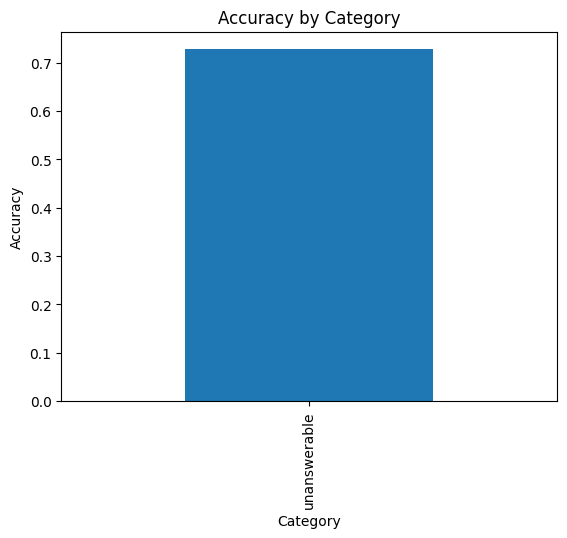

In [33]:
import matplotlib.pyplot as plt

category_accuracy.plot(kind="bar")
plt.title("Accuracy by Category")
plt.ylabel("Accuracy")
plt.xlabel("Category")
plt.savefig("/Users/krutikotadia/Desktop/DLP Project/accuracy_by_category.png")
plt.show()


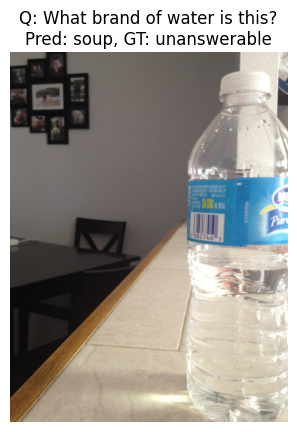

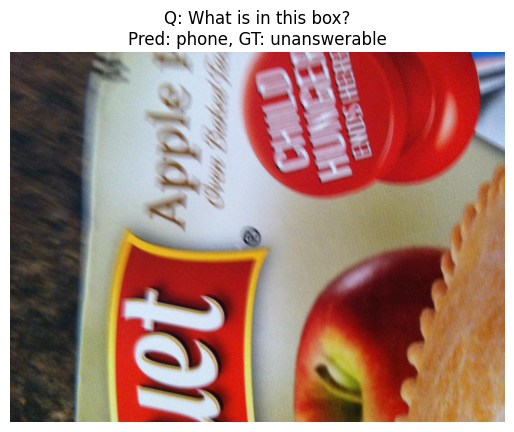

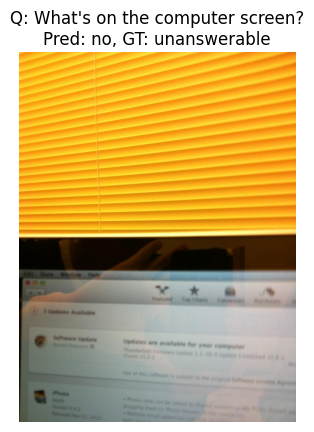

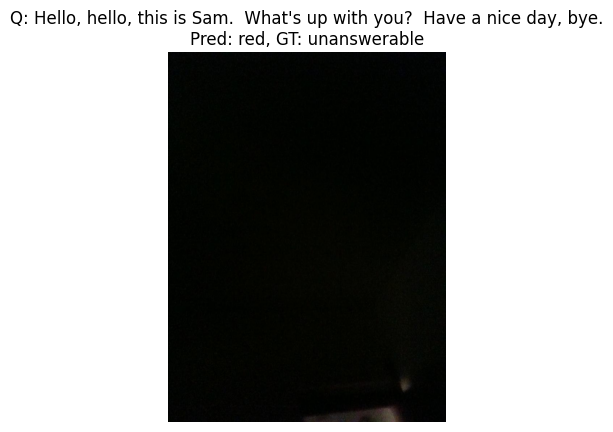

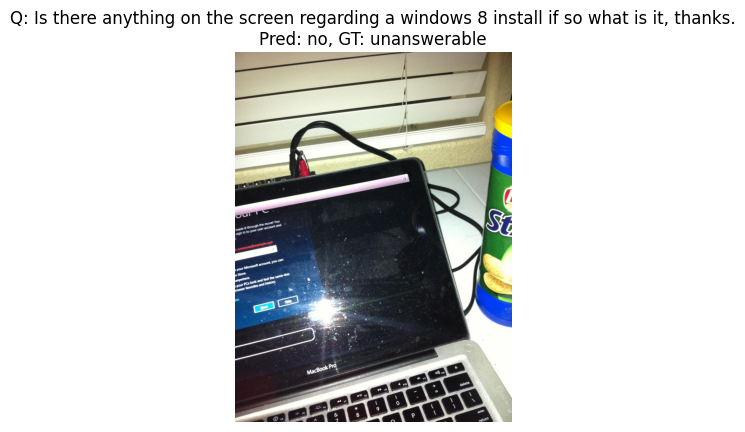

In [38]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Randomly select 5 examples from the incorrect results
random_samples = incorrect_results.sample(n=5, random_state=random.randint(0, 1000))

# Display each randomly selected example
for _, row in random_samples.iterrows():
    img_path = f"/Users/krutikotadia/Desktop/DLP Project/test/images_test/{row['Image']}"
    
    try:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Q: {row['Question']}\nPred: {row['Prediction']}, GT: {row['Ground Truth']}")
        plt.axis("off")
        plt.show()
    except FileNotFoundError:
        print(f"Image not found: {img_path}")


Displaying random answerable examples:
No answerable data found.
Displaying random unanswerable examples:


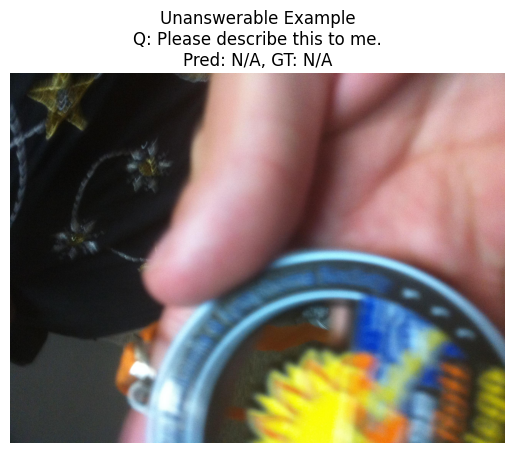

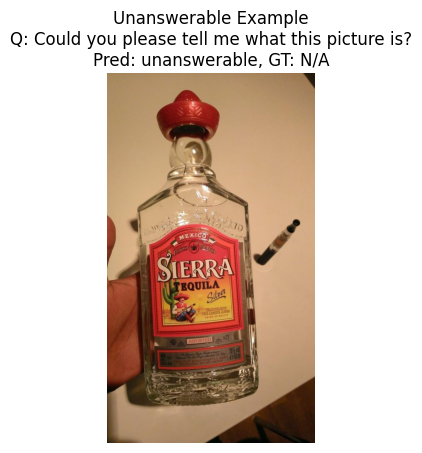

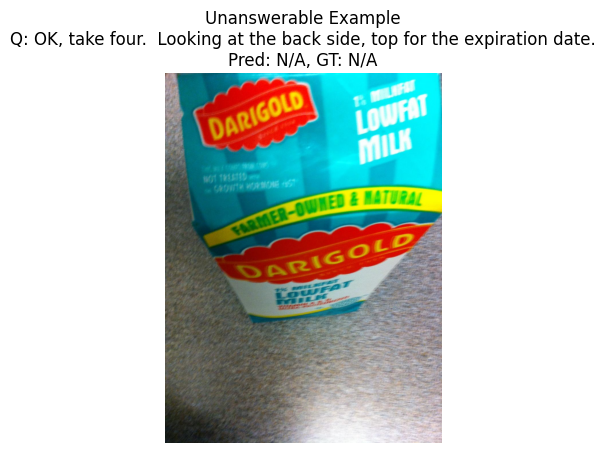

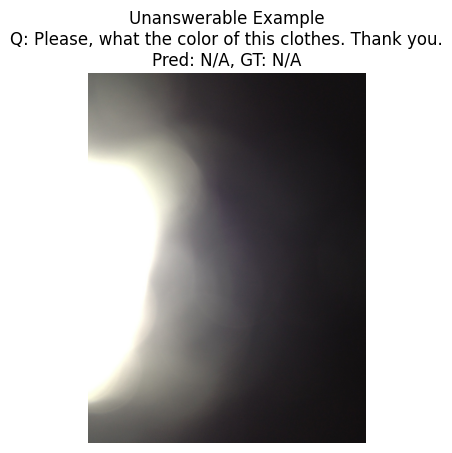

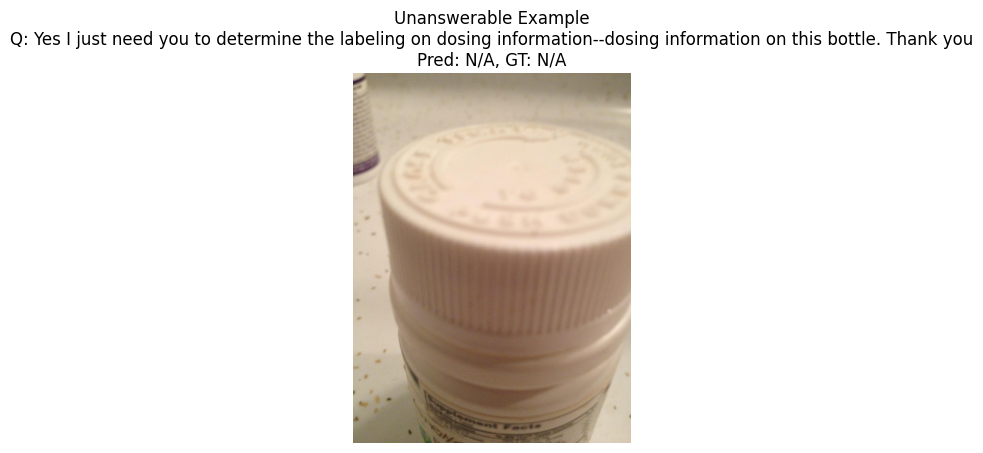

In [40]:
# import random
# import matplotlib.pyplot as plt
# from PIL import Image

# # Split data into answerable and unanswerable, handle missing 'answerable' keys
# answerable_data = [entry for entry in filtered_test_data if entry.get('answerable', 0) == 1]
# unanswerable_data = [entry for entry in filtered_test_data if entry.get('answerable', 0) == 0]

# # Function to display examples
# def display_examples(data, title):
#     random_samples = random.sample(data, min(5, len(data)))  # Select up to 5 random examples
#     for sample in random_samples:
#         img_path = f"/Users/krutikotadia/Desktop/DLP Project/test/images_test/{sample['image']}"
#         img = Image.open(img_path)

#         pred = sample.get('Prediction', 'N/A')
#         gt = sample.get('answer', 'N/A')  # Ground truth answer

#         plt.imshow(img)
#         plt.title(f"{title}\nQ: {sample['question']}\nPred: {pred}, GT: {gt}")
#         plt.axis("off")
#         plt.show()

# # Add predictions to the data for visualization
# for i, entry in enumerate(filtered_test_data[:len(decoded_predictions)]):
#     entry['Prediction'] = decoded_predictions[i]

# # Display random answerable examples
# print("Displaying random answerable examples:")
# if answerable_data:
#     display_examples(answerable_data, title="Answerable Example")
# else:
#     print("No answerable data found.")

# # Display random unanswerable examples
# print("Displaying random unanswerable examples:")
# if unanswerable_data:
#     display_examples(unanswerable_data, title="Unanswerable Example")
# else:
#     print("No unanswerable data found.")


In [41]:
# Check the number of answerable and unanswerable entries
answerable_count = sum(1 for entry in filtered_test_data if entry.get('answerable', 0) == 1)
unanswerable_count = sum(1 for entry in filtered_test_data if entry.get('answerable', 0) == 0)

print(f"Number of answerable entries: {answerable_count}")
print(f"Number of unanswerable entries: {unanswerable_count}")

# If no answerable data exists, print a warning
if answerable_count == 0:
    print("Warning: No answerable data found in the test dataset.")
if unanswerable_count == 0:
    print("Warning: No unanswerable data found in the test dataset.")


Number of answerable entries: 0
Number of unanswerable entries: 7323


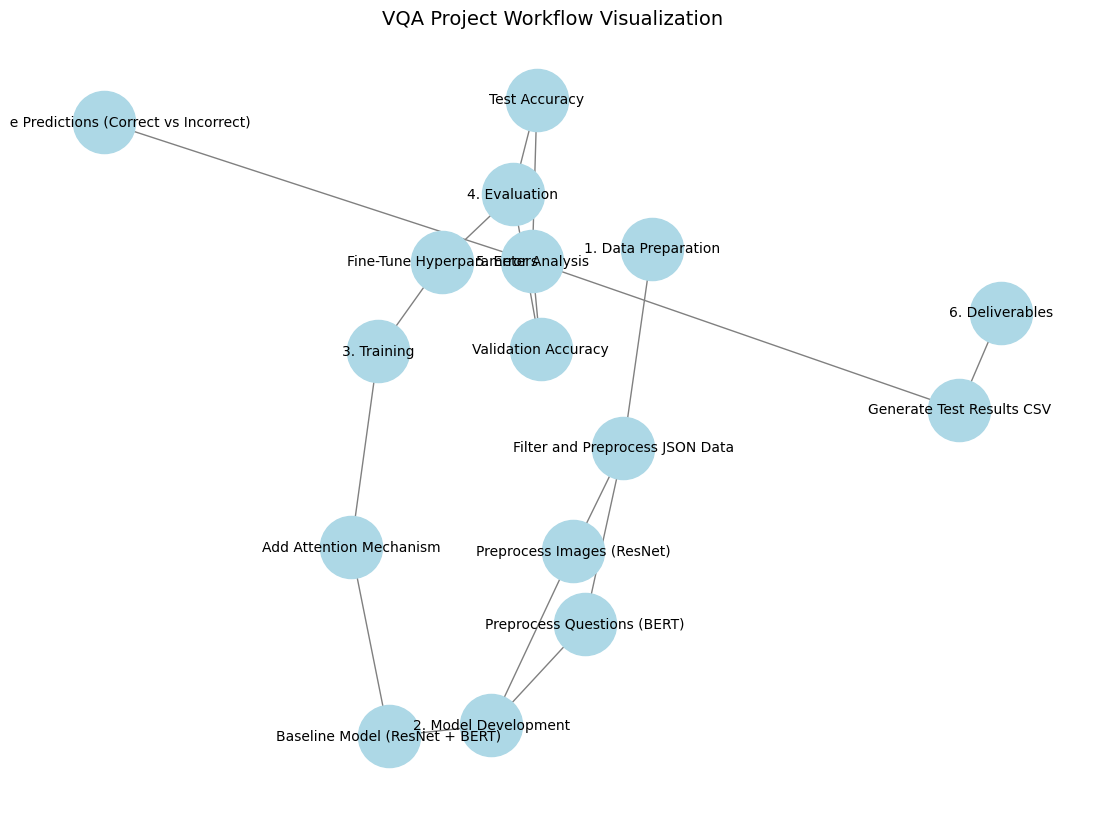

In [42]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_workflow():
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (steps of the project)
    steps = [
        "1. Data Preparation",
        "Filter and Preprocess JSON Data",
        "Preprocess Questions (BERT)",
        "Preprocess Images (ResNet)",
        "2. Model Development",
        "Baseline Model (ResNet + BERT)",
        "Add Attention Mechanism",
        "3. Training",
        "Fine-Tune Hyperparameters",
        "4. Evaluation",
        "Validation Accuracy",
        "Test Accuracy",
        "5. Error Analysis",
        "Visualize Predictions (Correct vs Incorrect)",
        "Generate Test Results CSV",
        "6. Deliverables"
    ]

    # Add edges (connections between steps)
    edges = [
        ("1. Data Preparation", "Filter and Preprocess JSON Data"),
        ("Filter and Preprocess JSON Data", "Preprocess Questions (BERT)"),
        ("Filter and Preprocess JSON Data", "Preprocess Images (ResNet)"),
        ("Preprocess Questions (BERT)", "2. Model Development"),
        ("Preprocess Images (ResNet)", "2. Model Development"),
        ("2. Model Development", "Baseline Model (ResNet + BERT)"),
        ("Baseline Model (ResNet + BERT)", "Add Attention Mechanism"),
        ("Add Attention Mechanism", "3. Training"),
        ("3. Training", "Fine-Tune Hyperparameters"),
        ("Fine-Tune Hyperparameters", "4. Evaluation"),
        ("4. Evaluation", "Validation Accuracy"),
        ("4. Evaluation", "Test Accuracy"),
        ("Test Accuracy", "5. Error Analysis"),
        ("Validation Accuracy", "5. Error Analysis"),
        ("5. Error Analysis", "Visualize Predictions (Correct vs Incorrect)"),
        ("5. Error Analysis", "Generate Test Results CSV"),
        ("Generate Test Results CSV", "6. Deliverables")
    ]

    # Add nodes and edges to the graph
    G.add_nodes_from(steps)
    G.add_edges_from(edges)

    # Draw the graph
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, seed=42)  # Position nodes using spring layout
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=2000)
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

    plt.title("VQA Project Workflow Visualization", fontsize=14)
    plt.axis("off")
    plt.show()

# Call the function to visualize the workflow
visualize_workflow()
